In [163]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import model_common
import xrd
import helpers as h
from importlib import reload
reload(model_common)
reload(xrd)
reload(h)

# MODEL_CHECKPOINT = 'checkpoints/dataset_1000_dl100_7d_v3_unweighted_full.pt'
# MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3_unweighted_full.pt'

# MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3_full.pt'

MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3_unweighted.pt'

# MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3_unweighted_ideal.pt'
# MODEL_CHECKPOINT = 'checkpoints/dataset_10000_dl100_7d_v3_unweighted_ideal_2.pt'

# true_params = [0.028500, 0.023000, 4.000e-05, 1.050e-05, 0.006000, 2.000e-05, -5.000e-06]
# true_params = [0.028500, 0.023000, 4.000e-05, 1.050e-05, 0.006000, 2.000e-05, -5.000e-06]
# from experiment file
true_params = [0.008094, 0.000943, 5200e-8, 3500e-8, 0.00255, 3000e-8, -50e-8]

original_curve, original_profile = xrd.compute_curve_and_profile(
    array=true_params,
    dl=100e-8
)

In [164]:
device = "mps"

# ============================================================================
# ЗАВАНТАЖИТИ МОДЕЛЬ
# ============================================================================
checkpoint = torch.load(MODEL_CHECKPOINT, map_location=device)
print(f"\n✅ Loaded checkpoint from {MODEL_CHECKPOINT}")
print(f"   Epoch: {checkpoint.get('epoch', 'N/A')}, Val loss: {checkpoint.get('val_loss', 'N/A')}")

model = model_common.XRDRegressor().to(device)
model.load_state_dict(checkpoint['model'])
model.eval()

# ============================================================================
# ПІДГОТУВАТИ ДАНІ (точно так само як в model_evaluate.py!)
# ============================================================================
# Створити dummy X (не використовується моделлю)
dummy_X = torch.tensor([0,0,0,0,0,0,0], dtype=torch.float32).unsqueeze(0)  # [1, 7]

# Підготувати криву Y
# input_Y = Y[sample_idx:sample_idx+1]  # [1, L]


if 'full' in MODEL_CHECKPOINT:
    print(f"\nℹ️ Using FULL curve for evaluation.")
    input_Y = torch.tensor(original_curve.Y_R_vseZ).unsqueeze(0)
else:
    print(f"\nℹ️ Using CROPPED curve for evaluation.")
    input_Y = torch.tensor(original_curve.ML_Y).unsqueeze(0)  # [1, L]

# Створити датасет з тими самими параметрами, що й при evaluate
ds = model_common.NormalizedXRDDataset(
    dummy_X, 
    input_Y,  # [1, L]
    log_space=True,  # ❗ ВАЖЛИВО - має співпадати з model_evaluate.py
    train=False
)

# ============================================================================
# PREDICTION
# ============================================================================
print(f"\n🔮 Running prediction...")
with torch.no_grad():
    y_normalized = ds.Yn[0].unsqueeze(0).to(device, dtype=torch.float32)  # [1, 1, L]
    pred_normalized = model(y_normalized)
    pred_params = model_common.denorm_params(pred_normalized)

predicted_from_dataset = pred_params[0].cpu().numpy()

print(f"\n📊 RESULTS:")
print(f"   True     : {h.fparam(arr=true_params)}")
print(f"   Predicted: {h.fparam(arr=predicted_from_dataset)}")


✅ Loaded checkpoint from checkpoints/dataset_10000_dl100_7d_v3_unweighted.pt
   Epoch: 80, Val loss: 0.00838627801090479

ℹ️ Using CROPPED curve for evaluation.

🔮 Running prediction...

📊 RESULTS:
   True     : Dmax1=0.0081, D01=0.0009, L1=5200 Rp1=3500, D02=0.0026, L2=3000, Rp2=-50
   Predicted: Dmax1=0.0076, D01=0.0011, L1=5342 Rp1=3522, D02=0.0025, L2=3690, Rp2=-2362


In [165]:
# Перевірка - виведемо predicted параметри
print("\n📋 DETAILED COMPARISON:")
print(f"{'Parameter':<10} {'True':<15} {'Predicted':<15} {'Error':<15}")
print("-" * 55)
for i, name in enumerate(model_common.PARAM_NAMES):
    true_val = true_params[i]
    pred_val = predicted_from_dataset[i]
    error = pred_val - true_val
    print(f"{name:<10} {true_val:<15.6e} {pred_val:<15.6e} {error:+15.6e}")


📋 DETAILED COMPARISON:
Parameter  True            Predicted       Error          
-------------------------------------------------------
Dmax1      8.094000e-03    7.567722e-03      -5.262778e-04
D01        9.430000e-04    1.107251e-03      +1.642511e-04
L1         5.200000e-05    5.341688e-05      +1.416880e-06
Rp1        3.500000e-05    3.521857e-05      +2.185698e-07
D02        2.550000e-03    2.470654e-03      -7.934612e-05
L2         3.000000e-05    3.690328e-05      +6.903279e-06
Rp2        -5.000000e-07   -2.361962e-05     -2.311962e-05


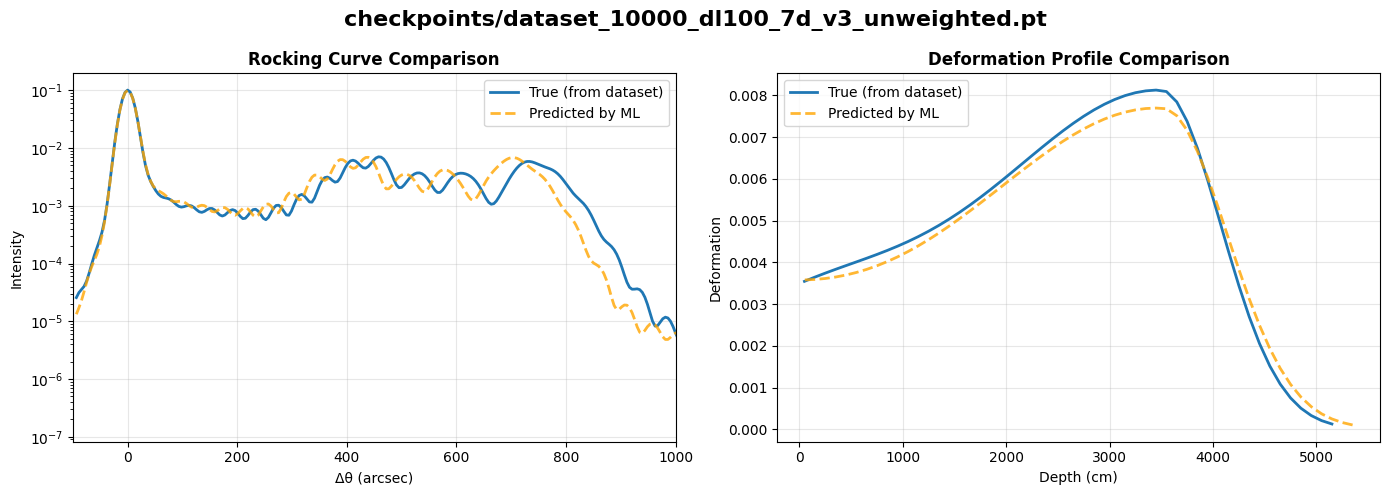

In [166]:
import matplotlib.pyplot as plt
import xrd
from importlib import reload
reload(xrd)

# ============================================================================
# ГЕНЕРУВАТИ ПОВНІ КРИВІ ДЛЯ ВІЗУАЛІЗАЦІЇ
# ============================================================================

# True curve (з параметрів з датасету)
true_curve, true_profile = xrd.compute_curve_and_profile(
    array=true_params,
    dl=100e-8
)

# Predicted curve (з predicted параметрів)
predicted_curve, predicted_profile = xrd.compute_curve_and_profile(
    array=predicted_from_dataset.tolist(),
    dl=100e-8
)

# ============================================================================
# ВІЗУАЛІЗАЦІЯ
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

fig.suptitle(MODEL_CHECKPOINT, fontsize=16, fontweight='bold')

# Rocking Curve
axes[0].set_title("Rocking Curve Comparison", fontsize=12, fontweight='bold')
axes[0].plot(true_curve.X_DeltaTeta, true_curve.Y_R_vseZ, 
             label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
axes[0].plot(predicted_curve.X_DeltaTeta, predicted_curve.Y_R_vseZ, 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
axes[0].set_xlabel("Δθ (arcsec)")
axes[0].set_ylabel("Intensity")
# axes[0].set_ylim(0, 0.004)
axes[0].set_xlim(-100, 1000)
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Deformation Profile
axes[1].set_title("Deformation Profile Comparison", fontsize=12, fontweight='bold')
axes[1].plot(true_profile.X, true_profile.total_Y, 
             label="True (from dataset)", color='C0', linestyle='-', linewidth=2)
axes[1].plot(predicted_profile.X, predicted_profile.total_Y, 
             label="Predicted by ML", color='orange', linestyle='--', linewidth=2, alpha=0.8)
axes[1].set_xlabel("Depth (cm)")
axes[1].set_ylabel("Deformation")
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()